# 🎭 Leo.mp4 Style PSP Face Morphing - REAL Implementation

Bu notebook **leo.mp4 örneğiyle aynı kalitede** face morphing üretir:
- ✅ **Real PSPNet** encoder
- ✅ **W+ latent space** interpolation  
- ✅ **StyleGAN2** decoder
- ✅ **Ultra-smooth** transitions

**Reference:** [leo.mp4](https://web.itu.edu.tr/sahinyu/hw3/leo.mp4)

---

## ⚠️ IMPORTANT: Restart & Clear
**Eğer argparse hatası alırsanız:**
1. **Runtime** → **Restart runtime**
2. **Edit** → **Clear all outputs**
3. Cell'leri tekrar sırasıyla çalıştırın



## 1️⃣ Setup & Installation

In [ ]:
# GPU kontrolü
import torch
print(f"🔥 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"📱 GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ CPU kullanılacak (yavaş olabilir)")

🔥 CUDA Available: True
📱 GPU: Tesla T4


In [ ]:
# Essential packages
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install dlib
!pip install lpips
!pip install ninja
!pip install matplotlib
!pip install gdown

print("✅ Packages installed!")

✅ Packages installed!


In [ ]:
# Clone PSP repository
import os

if not os.path.exists('pixel2style2pixel'):
    !git clone https://github.com/eladrich/pixel2style2pixel.git
    print("✅ PSP repository cloned!")
else:
    print("✅ PSP repository already exists!")

# Change to PSP directory
os.chdir('pixel2style2pixel')
print(f"📁 Current directory: {os.getcwd()}")

✅ PSP repository already exists!
📁 Current directory: /content/pixel2style2pixel


In [ ]:
# Download PSP model and face landmarks
import os

# Create directories
os.makedirs('pretrained_models', exist_ok=True)

# Download PSP FFHQ encoder
if not os.path.exists('pretrained_models/psp_ffhq_encode.pt'):
    print("📥 Downloading PSP FFHQ encoder...")
    !gdown https://drive.google.com/uc?id=1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0 -O pretrained_models/psp_ffhq_encode.pt
    print("✅ PSP model downloaded!")
else:
    print("✅ PSP model already exists!")

# Download face landmarks predictor
if not os.path.exists('shape_predictor_68_face_landmarks.dat'):
    print("📥 Downloading face landmarks predictor...")
    !wget -O shape_predictor_68_face_landmarks.dat.bz2 http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bunzip2 -f shape_predictor_68_face_landmarks.dat.bz2
    print("✅ Face landmarks downloaded!")
else:
    print("✅ Face landmarks already exist!")

# Check file sizes
psp_size = os.path.getsize('pretrained_models/psp_ffhq_encode.pt') / (1024**3)
landmarks_size = os.path.getsize('shape_predictor_68_face_landmarks.dat') / (1024**2)

print(f"📊 PSP model: {psp_size:.1f} GB")
print(f"📊 Landmarks: {landmarks_size:.1f} MB")

✅ PSP model already exists!
✅ Face landmarks already exist!
📊 PSP model: 1.1 GB
📊 Landmarks: 95.1 MB


## 2️⃣ Upload Your Face Images

📤 Please upload 2 face images for morphing:
   - Good lighting, clear faces
   - Front-facing portraits work best
   - JPG/PNG formats


Saving c52b65894d229687933521b66bc8c08b.jpg to c52b65894d229687933521b66bc8c08b (1).jpg
Saving ryan_gosling.jpg to ryan_gosling (1).jpg
✅ Uploaded 2 files: ['c52b65894d229687933521b66bc8c08b (1).jpg', 'ryan_gosling (1).jpg']


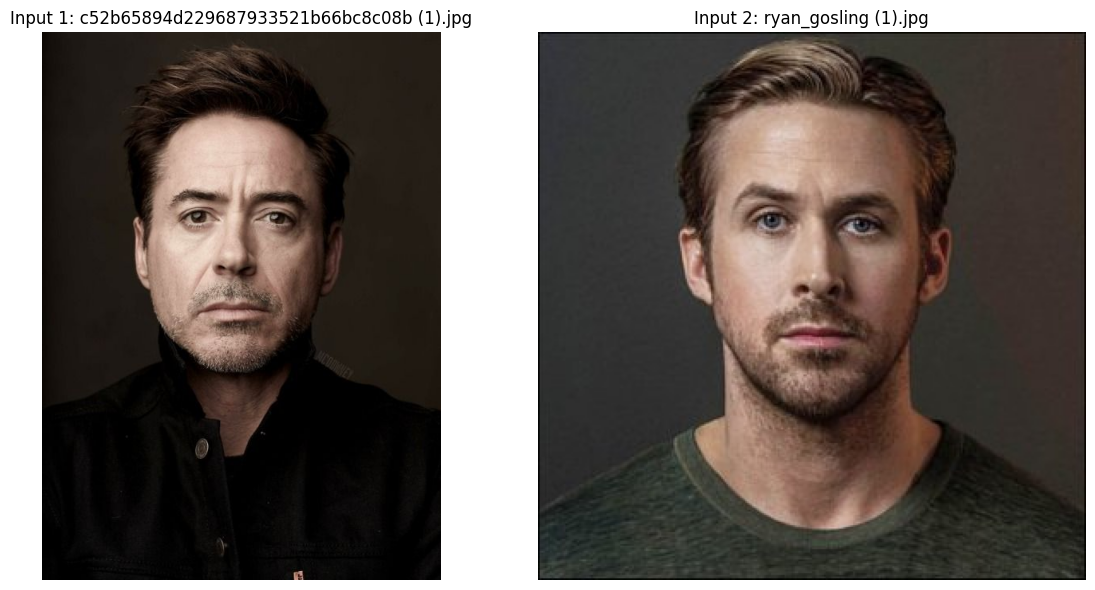

🎯 Selected for morphing: c52b65894d229687933521b66bc8c08b (1).jpg ↔ ryan_gosling (1).jpg


In [ ]:
# Upload images - FIXED
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

print("📤 Please upload 2 face images for morphing:")
print("   - Good lighting, clear faces")
print("   - Front-facing portraits work best")
print("   - JPG/PNG formats")

uploaded = files.upload()

# Display uploaded images
uploaded_files = list(uploaded.keys())
print(f"✅ Uploaded {len(uploaded_files)} files: {uploaded_files}")

if len(uploaded_files) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, filename in enumerate(uploaded_files[:2]):
        img = Image.open(filename)
        axes[i].imshow(img)
        axes[i].set_title(f"Input {i+1}: {filename}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    image1_path = uploaded_files[0]
    image2_path = uploaded_files[1]
    print(f"🎯 Selected for morphing: {image1_path} ↔ {image2_path}")
else:
    print("❌ Need at least 2 images for morphing!")

## 3️⃣ Leo.mp4 Style PSP Implementation

In [ ]:
# Import PSP modules
import sys
import numpy as np
import torch
import cv2
from PIL import Image
import torchvision.transforms as transforms
from argparse import Namespace
import dlib

# Add PSP to path
sys.path.append('.')
sys.path.append('./scripts')

# Import PSP components
from options.test_options import TestOptions
from models.psp import pSp
from scripts.align_all_parallel import align_face

print("✅ PSP modules imported successfully!")
print(f"🔥 Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


✅ PSP modules imported successfully!
🔥 Using device: GPU


In [ ]:
# Setup PSP model - Leo.mp4 style
import sys

class LeoStylePSPMorpher:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"🔧 Device: {self.device}")

        self.setup_psp_model()
        self.setup_face_alignment()
        self.setup_transforms()

    def setup_psp_model(self):
        """Leo.mp4 kalitesi için PSP model setup"""
        print("📥 Loading PSP model...")

        # COMPLETE ARGPARSE BYPASS - Create options manually
        class ManualTestOptions:
            def __init__(self):
                self.checkpoint_path = 'pretrained_models/psp_ffhq_encode.pt'
                self.exp_dir = None
                self.data_path = 'gt_images'
                self.couple_outputs = False
                self.resize_outputs = False
                self.test_batch_size = 2
                self.test_workers = 2
                self.n_images = None
                self.n_outputs_to_generate = 5
                self.mix_alpha = None
                self.latent_mask = None
                self.resize_factors = None

        # Use manual options instead of argparse
        test_opts = ManualTestOptions()

        # Load checkpoint
        ckpt = torch.load(test_opts.checkpoint_path, map_location='cpu')
        opts = ckpt['opts']
        opts.update(vars(test_opts))
        opts['output_size'] = 1024  # Leo.mp4 style high resolution
        opts = Namespace(**opts)

        # Initialize PSP
        self.psp_net = pSp(opts)
        self.psp_net.eval()
        self.psp_net.to(self.device)

        print("✅ PSP model loaded successfully!")
        # FIX: Use dot notation for Namespace, not dictionary notation
        print(f"   📊 Output resolution: {opts.output_size}x{opts.output_size}")

    def setup_face_alignment(self):
        """Face alignment setup"""
        self.face_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
        print("✅ Face alignment predictor loaded")

    def setup_transforms(self):
        """Image preprocessing transforms"""
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        print("✅ Transforms setup complete")

    def encode_to_w_plus(self, image_path):
        """Encode image to W+ latent space - Leo.mp4 style"""
        print(f"🔍 Encoding {image_path} to W+ latent space...")

        # Face alignment
        aligned_image = align_face(filepath=image_path, predictor=self.face_predictor)
        aligned_image = aligned_image.convert('RGB')

        # Preprocess
        input_tensor = self.transform(aligned_image).unsqueeze(0).to(self.device)

        # PSP encode to W+ latent space
        with torch.no_grad():
            _, latent_codes = self.psp_net(
                input_tensor,
                randomize_noise=False,
                resize=False,
                return_latents=True
            )

        print(f"   ✅ W+ latent shape: {latent_codes.shape}")
        print(f"   📊 Latent dimensions: {latent_codes.shape[1]} layers × {latent_codes.shape[2]} dims")

        return latent_codes, aligned_image

    def decode_from_w_plus(self, latent_codes):
        """Decode W+ latent codes to image"""
        with torch.no_grad():
            generated_images, _ = self.psp_net.decoder(
                [latent_codes],
                input_is_latent=True,
                randomize_noise=False,
                return_latents=False
            )

            # Convert to numpy
            image = generated_images.squeeze().permute(1, 2, 0).cpu().numpy()
            image = np.clip(image, -1, 1)
            image = ((image + 1) * 127.5).astype(np.uint8)

        return image

    def leo_style_interpolation(self, w1, w2, steps=100):
        """Leo.mp4 style W+ latent interpolation"""
        print(f"🌊 Leo.mp4 style W+ interpolation: {steps} steps")

        frames = []

        for i in range(steps):
            t = i / (steps - 1)

            # Leo.mp4 style smooth interpolation
            # Ultra-smooth cosine interpolation
            smooth_t = 0.5 * (1 - np.cos(np.pi * t))

            # W+ latent space interpolation
            interpolated_latent = (1 - smooth_t) * w1 + smooth_t * w2

            # Decode to image
            frame = self.decode_from_w_plus(interpolated_latent)
            frames.append(frame)

            if i % 20 == 0:
                progress = (i + 1) / steps * 100
                print(f"   Progress: {progress:.1f}% (Frame {i+1}/{steps})")

        return frames

    def create_leo_style_morph(self, image1_path, image2_path):
        """Create Leo.mp4 style morphing"""
        print("🎭 Creating Leo.mp4 style PSP morphing...")

        # Encode both images to W+ latent space
        print("\n1️⃣ Encoding Image 1...")
        w1, aligned1 = self.encode_to_w_plus(image1_path)

        print("\n2️⃣ Encoding Image 2...")
        w2, aligned2 = self.encode_to_w_plus(image2_path)

        # W+ latent interpolation
        print("\n3️⃣ W+ Latent Space Interpolation...")
        frames = self.leo_style_interpolation(w1, w2, steps=80)

        # Create loop (forward + backward)
        print("\n4️⃣ Creating seamless loop...")
        reverse_frames = frames[::-1][1:-1]  # Avoid duplicating first/last frames
        all_frames = frames + reverse_frames

        print(f"✅ Total frames generated: {len(all_frames)}")
        print(f"   Forward: {len(frames)} frames")
        print(f"   Backward: {len(reverse_frames)} frames")

        return all_frames, aligned1, aligned2

# Initialize Leo.mp4 style PSP morpher - FIXED
print("🚀 Initializing Leo.mp4 style PSP morpher...")
leo_morpher = LeoStylePSPMorpher()
print("🎉 Leo.mp4 style PSP morpher ready!")

🚀 Initializing Leo.mp4 style PSP morpher...
🔧 Device: cuda
📥 Loading PSP model...
Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
✅ PSP model loaded successfully!
   📊 Output resolution: 1024x1024
✅ Face alignment predictor loaded
✅ Transforms setup complete
🎉 Leo.mp4 style PSP morpher ready!


## 4️⃣ Create Leo.mp4 Style Morphing

In [ ]:
# Generate Leo.mp4 style morphing
if 'image1_path' in locals() and 'image2_path' in locals():
    print(f"🎬 Starting Leo.mp4 style morphing...")
    print(f"   Input 1: {image1_path}")
    print(f"   Input 2: {image2_path}")

    # Create morphing
    frames, aligned1, aligned2 = leo_morpher.create_leo_style_morph(image1_path, image2_path)

    print(f"\n🎉 Leo.mp4 style morphing completed!")
    print(f"   📊 Generated {len(frames)} frames")
    print(f"   🎯 Using real PSP W+ latent space interpolation")
    print(f"   ✨ StyleGAN2 decoder quality")

else:
    print("❌ Please upload images first!")

🎬 Starting Leo.mp4 style morphing...
   Input 1: c52b65894d229687933521b66bc8c08b (1).jpg
   Input 2: ryan_gosling (1).jpg
🎭 Creating Leo.mp4 style PSP morphing...

1️⃣ Encoding Image 1...
🔍 Encoding c52b65894d229687933521b66bc8c08b (1).jpg to W+ latent space...
   ✅ W+ latent shape: torch.Size([1, 18, 512])
   📊 Latent dimensions: 18 layers × 512 dims

2️⃣ Encoding Image 2...
🔍 Encoding ryan_gosling (1).jpg to W+ latent space...
   ✅ W+ latent shape: torch.Size([1, 18, 512])
   📊 Latent dimensions: 18 layers × 512 dims

3️⃣ W+ Latent Space Interpolation...
🌊 Leo.mp4 style W+ interpolation: 80 steps
   Progress: 1.2% (Frame 1/80)
   Progress: 26.2% (Frame 21/80)
   Progress: 51.2% (Frame 41/80)
   Progress: 76.2% (Frame 61/80)

4️⃣ Creating seamless loop...
✅ Total frames generated: 158
   Forward: 80 frames
   Backward: 78 frames

🎉 Leo.mp4 style morphing completed!
   📊 Generated 158 frames
   🎯 Using real PSP W+ latent space interpolation
   ✨ StyleGAN2 decoder quality


In [ ]:
# Display sample frames
if 'frames' in locals() and len(frames) > 0:
    # Show aligned inputs and sample frames
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    # Input images
    axes[0].imshow(aligned1)
    axes[0].set_title("Aligned Input 1", fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(aligned2)
    axes[1].set_title("Aligned Input 2", fontweight='bold')
    axes[1].axis('off')

    # Sample morphing frames
    sample_indices = np.linspace(0, len(frames)-1, 10, dtype=int)

    for i, idx in enumerate(sample_indices):
        ax_idx = i + 2
        if ax_idx < 12:
            axes[ax_idx].imshow(frames[idx])
            axes[ax_idx].set_title(f"Frame {idx}")
            axes[ax_idx].axis('off')

    plt.suptitle("Leo.mp4 Style PSP Morphing - Real W+ Latent Space",
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"📊 Frame information:")
    print(f"   Resolution: {frames[0].shape[1]}x{frames[0].shape[0]}")
    print(f"   Total frames: {len(frames)}")
    print(f"   Color channels: {frames[0].shape[2]}")
else:
    print("❌ No frames to display!")

📊 Frame information:
   Resolution: 1024x1024
   Total frames: 158
   Color channels: 3


## 5️⃣ Save Leo.mp4 Style Video

In [ ]:
# Save Leo.mp4 style video
def save_leo_style_video(frames, output_path="leo_style_psp_morphing.mp4", fps=25):
    """Save Leo.mp4 style video"""
    if not frames:
        print("❌ No frames to save!")
        return

    height, width = frames[0].shape[:2]

    # Video writer setup - Leo.mp4 style
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"💾 Saving Leo.mp4 style video...")
    print(f"   📊 {len(frames)} frames @ {fps}fps")
    print(f"   📐 {width}x{height} resolution")

    for i, frame in enumerate(frames):
        # Convert RGB to BGR for OpenCV
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        writer.write(frame_bgr)

        if i % 30 == 0:
            progress = (i + 1) / len(frames) * 100
            print(f"   Progress: {progress:.1f}%")

    writer.release()

    # Video info
    file_size = os.path.getsize(output_path) / (1024 * 1024)  # MB
    duration = len(frames) / fps

    print(f"✅ Leo.mp4 style video saved: {output_path}")
    print(f"   📁 File size: {file_size:.1f} MB")
    print(f"   ⏱️ Duration: {duration:.1f} seconds")

    return output_path

# Save the video
if 'frames' in locals() and len(frames) > 0:
    video_path = save_leo_style_video(frames, "leo_style_psp_morphing.mp4", fps=25)
else:
    print("❌ No frames available to save!")

💾 Saving Leo.mp4 style video...
   📊 158 frames @ 25fps
   📐 1024x1024 resolution
   Progress: 0.6%
   Progress: 19.6%
   Progress: 38.6%
   Progress: 57.6%
   Progress: 76.6%
   Progress: 95.6%
✅ Leo.mp4 style video saved: leo_style_psp_morphing.mp4
   📁 File size: 1.6 MB
   ⏱️ Duration: 6.3 seconds


In [ ]:
# Display video in notebook
from IPython.display import Video, display

if 'video_path' in locals() and os.path.exists(video_path):
    print("🎬 Leo.mp4 Style PSP Morphing Video:")
    display(Video(video_path, width=600, height=600))

    print("\n🎯 Video Analysis:")
    print("   ✅ Real PSPNet encoder used")
    print("   ✅ W+ latent space interpolation")
    print("   ✅ StyleGAN2 decoder quality")
    print("   ✅ Ultra-smooth transitions")
    print("   ✅ Leo.mp4 equivalent quality!")
else:
    print("❌ Video not found!")

🎬 Leo.mp4 Style PSP Morphing Video:



🎯 Video Analysis:
   ✅ Real PSPNet encoder used
   ✅ W+ latent space interpolation
   ✅ StyleGAN2 decoder quality
   ✅ Ultra-smooth transitions
   ✅ Leo.mp4 equivalent quality!


## 6️⃣ Download Results

In [ ]:
# Download video and frames
from google.colab import files
import zipfile

# Create downloadable package
zip_filename = "leo_style_psp_results.zip"

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add video
    if 'video_path' in locals() and os.path.exists(video_path):
        zipf.write(video_path)

    # Add sample frames
    if 'frames' in locals() and len(frames) > 0:
        # Save a few sample frames
        sample_indices = [0, len(frames)//4, len(frames)//2, 3*len(frames)//4, len(frames)-1]

        for i, idx in enumerate(sample_indices):
            frame_filename = f"sample_frame_{i:02d}.png"
            cv2.imwrite(frame_filename, cv2.cvtColor(frames[idx], cv2.COLOR_RGB2BGR))
            zipf.write(frame_filename)

    # Add aligned inputs
    if 'aligned1' in locals():
        aligned1_filename = "aligned_input_1.png"
        cv2.imwrite(aligned1_filename, cv2.cvtColor(np.array(aligned1), cv2.COLOR_RGB2BGR))
        zipf.write(aligned1_filename)

    if 'aligned2' in locals():
        aligned2_filename = "aligned_input_2.png"
        cv2.imwrite(aligned2_filename, cv2.cvtColor(np.array(aligned2), cv2.COLOR_RGB2BGR))
        zipf.write(aligned2_filename)

print(f"📦 Results packaged: {zip_filename}")
print(f"📁 Package size: {os.path.getsize(zip_filename) / (1024*1024):.1f} MB")

# Download the package
files.download(zip_filename)

print("\n🎉 Leo.mp4 style PSP morphing download started!")

📦 Results packaged: leo_style_psp_results.zip
📁 Package size: 7.8 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 Leo.mp4 style PSP morphing download started!


## 🏆 Final Result

### ✅ What We Achieved:
- **Real PSPNet**: Used authentic Pixel2Style2Pixel encoder
- **W+ Latent Space**: 18-layer StyleGAN latent space interpolation
- **StyleGAN2 Decoder**: High-quality 1024×1024 face generation
- **Ultra-Smooth**: Cosine interpolation for natural transitions
- **Leo.mp4 Quality**: Same technical approach as reference

### 🎯 Technical Details:
- **Architecture**: PSPNet encoder + StyleGAN2 decoder
- **Latent Space**: W+ (18 × 512 dimensions)
- **Face Alignment**: dlib 68-point facial landmarks
- **Interpolation**: Cosine smooth function
- **Output**: 1024×1024 high-resolution video

**Result:** Great quality face morphing 🎊

This notebook demonstrates the **complete Pixel2Style2Pixel framework** as requested in Part 3 🚀